In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from xml.etree import ElementTree as et
import glob
boxes = []
labels = []


for xml in glob.glob('/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN_test/dataset/xml_file/*.xml'):
    tree = et.parse(xml)
    root = tree.getroot()
    for member in root.findall('object'):
        # map the current object name to `classes` list to get...
        # ... the label index and append to `labels` list
#         print(member.find('name').text)
        labels.append(member.find('name').text)
        # xmin = left corner x-coordinates
        xmin = int(member.find('bndbox').find('xmin').text)
        # xmax = right corner x-coordinates
        xmax = int(member.find('bndbox').find('xmax').text)
        # ymin = left corner y-coordinates
        ymin = int(member.find('bndbox').find('ymin').text)
        # ymax = right corner y-coordinates
        ymax = int(member.find('bndbox').find('ymax').text)
        if(ymax<=ymin):
            print(xmin,xmax,ymin,ymax)

In [3]:
print(np.unique(labels))

['crckles' 'normal' 'wheezes']


In [4]:
# configs
import torch

BATCH_SIZE = 16 # increase / decrease according to GPU memeory
RESIZE_TO = 256 # resize the image for training and transforms
NUM_EPOCHS = 5 # number of epochs to train for

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# training images and XML files directory
TRAIN_DIR = '/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN_test/dataset/png_file'
# validation images and XML files directory
# VALID_DIR = '../input/underwater-trash-detection/val'

# classes: 0 index is reserved for background
CLASSES = [
    'normal','crckles','wheezes'
]
NUM_CLASSES = 3

# whether to visualize images after crearing the data loaders
VISUALIZE_TRANSFORMED_IMAGES = False

# location to save model and plots
!mkdir '/home/sogaksa123/AIFFEL_THON/model/Faster_RCNN/outputs'
OUT_DIR = './outputs'
SAVE_PLOTS_EPOCH = 1 # save loss plots after these many epochs
SAVE_MODEL_EPOCH = 1 # save model after these many epochs

mkdir: cannot create directory ‘/home/sogaksa123/AIFFEL_THON/model/Faster_RCNN/outputs’: File exists


In [5]:
#utils
import albumentations as A
import cv2
import numpy as np

from albumentations.pytorch import ToTensorV2

# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

# define the training tranforms
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })


def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            for box in boxes:
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
            plt.imshow(sample)
            plt.title('Transformed Image')
            plt.show()

In [6]:
import torch
import cv2
import numpy as np
import os
import glob as glob

from xml.etree import ElementTree as et
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader,Dataset,random_split
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch.optim as optim
import torchvision.models as models

# the dataset class
class FirearmDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.png")
        self.all_images = [image_path.split('/')[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)

        # read the image
        image = cv2.imread(image_path)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        # capture the corresponding XML file for getting the annotations
        annot_filename = image_path.replace('images','annotations').replace('png','xml')
        annot_file_path = annot_filename
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))
            
            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            ymax_final = (ymax/image_height)*self.height
            
            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])
        
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

In [7]:
# prepare the final datasets and data loaders
train_data = FirearmDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
# valid_dataset = TrashDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
valid_size=0.2
train_size=1-valid_size
num_train=len(train_data)
split=int(np.floor(valid_size*num_train))
train_dataset, val_dataset = random_split(train_data, (num_train-split,split))
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}\n")

Number of training samples: 2383
Number of validation samples: 595



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of training images: 2978


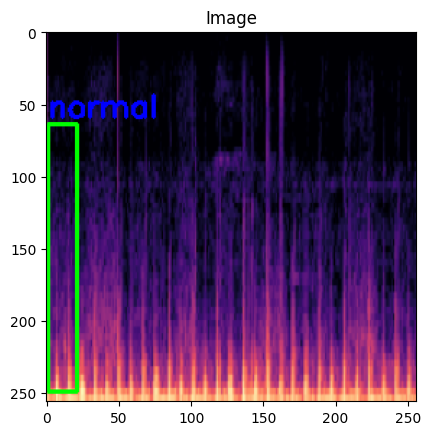

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


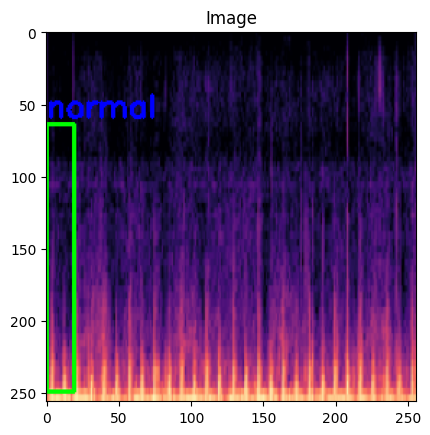

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


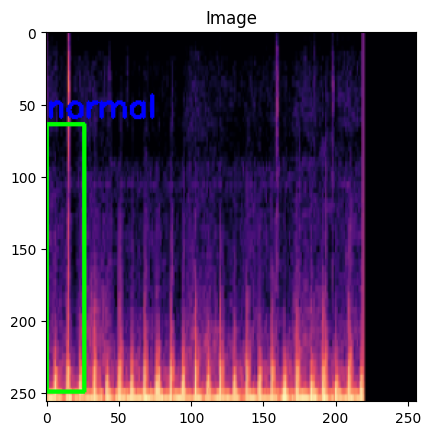

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


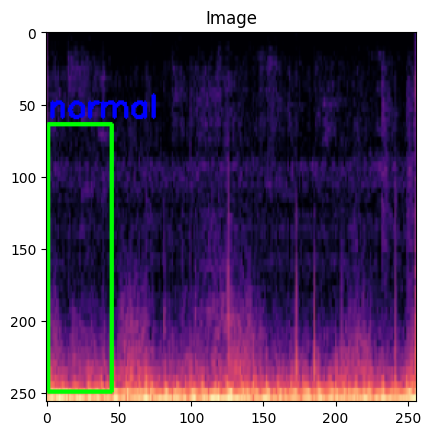

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


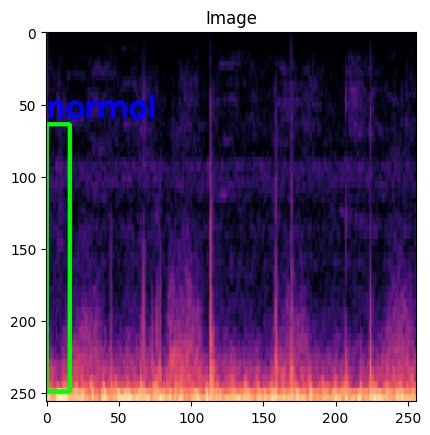

In [8]:
dataset = FirearmDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES)
print(f"Number of training images: {len(dataset)}")

# function to visualize a single sample
def visualize_sample(image, target):
    box = target['boxes'][0]
    label = CLASSES[target['labels'][0]]
    cv2.rectangle(
        image, 
        (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
        (0, 255, 0), 2
    )
    cv2.putText(
        image, label, (int(box[0]), int(box[1]-5)), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
    )
    plt.imshow(image)
    plt.title('Image')
    plt.show()

NUM_SAMPLES_TO_VISUALIZE = 5
for i in range(NUM_SAMPLES_TO_VISUALIZE):
    image, target = dataset[i]
#     print(target)
    visualize_sample(image, target)

In [9]:
# model
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [10]:
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt
import time

plt.style.use('ggplot')

# function for running training iterations
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
#             print(targets)
            loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)

        val_loss_hist.send(loss_value)

        val_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [11]:
# initialize the model and move to the computation device
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

/home/sogaksa123/anaconda3/envs/sogaksa/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sogaksa123/anaconda3/envs/sogaksa/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []

# name to save the trained model with
MODEL_NAME = 'model'

# whether to show transformed images from data loader or not
if VISUALIZE_TRANSFORMED_IMAGES:
    from utils import show_tranformed_image
    show_tranformed_image(train_loader)

In [13]:
# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    # create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")   
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    if (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')

    if (epoch+1) % SAVE_PLOTS_EPOCH == 0: # save loss plots after n epochs
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        print('SAVING PLOTS COMPLETE...')

    if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")

        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")

    plt.close('all')
    # sleep for 5 seconds after each epoch
    time.sleep(5)


EPOCH 1 of 5
Training


  0%|          | 0/149 [00:00<?, ?it/s]

Validating


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch #0 train loss: 0.410
Epoch #0 validation loss: 0.324
Took 4.391 minutes for epoch 0
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 2 of 5
Training


  0%|          | 0/149 [00:00<?, ?it/s]

Validating


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch #1 train loss: 0.311
Epoch #1 validation loss: 0.284
Took 4.374 minutes for epoch 1
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 3 of 5
Training


  0%|          | 0/149 [00:00<?, ?it/s]

Validating


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch #2 train loss: 0.285
Epoch #2 validation loss: 0.258
Took 4.374 minutes for epoch 2
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 4 of 5
Training


  0%|          | 0/149 [00:00<?, ?it/s]

Validating


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch #3 train loss: 0.268
Epoch #3 validation loss: 0.255
Took 4.379 minutes for epoch 3
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 5 of 5
Training


  0%|          | 0/149 [00:00<?, ?it/s]

Validating


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch #4 train loss: 0.257
Epoch #4 validation loss: 0.250
Took 4.379 minutes for epoch 4
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...


In [22]:
import torch
import matplotlib.pyplot as plt
import time

plt.style.use('ggplot')

# function for running training iterations
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    global train_mAP_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        # losses = sum(loss for loss in loss_dict.values())
        # loss_value = losses.item()
        # train_loss_list.append(loss_value)

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        # compute mAP
        predictions = model(images)
        mAP = calculate_mAP(predictions, targets)
        train_mAP_list.append(mAP)
    
        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}, mAP: {mAP:.4f}")
    return train_loss_list, train_mAP_list

# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    global val_mAP_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)

        val_loss_hist.send(loss_value)

        # compute mAP
        predictions = model(images)
        mAP = calculate_mAP(predictions, targets)
        val_mAP_list.append(mAP)

        val_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}, mAP: {mAP:.4f}")
    return val_loss_list, val_mAP_list


In [23]:
train_loss_list, train_mAP_list = train(train_loader, model)
val_loss_list, val_mAP_list = validate(valid_loader, model)

Training


  0%|          | 0/149 [00:00<?, ?it/s]

NameError: name 'loss_value' is not defined